---
title: "height data"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---


I found growth curves for girls and boys in Israel:

* [url girls](https://www.gov.il/BlobFolder/reports/kidsandmatures-curves/he/subjects_children-adolescents_g-height-age-5-19.pdf), <a href="/archive/data/subjects_children-adolescents_g-height-age-5-19.pdf" download>pdf girls</a>
* [url boys](https://www.gov.il/BlobFolder/reports/kidsandmatures-curves/he/subjects_children-adolescents_B-height-age-5-19.pdf), <a href="/archive/data/subjects_children-adolescents_B-height-age-5-19.pdf" download>pdf boys</a>
* [url both](https://briuton.co.il/4587/%D7%A2%D7%A7%D7%95%D7%9E%D7%95%D7%AA-%D7%92%D7%93%D7%99%D7%9C%D7%94-%D7%91%D7%A0%D7%99%D7%9D-%D7%95%D7%91%D7%A0%D7%95%D7%AA/), <a href="/archive/data/boys_chart3.png" download>png boys</a>, <a href="/archive/data/girls_chart1.png" download>png girls</a>.

For example, see this:

![](/archive/data/boys_chart3.png)


I used the great online resource [Web Plot Digitizer v4](https://apps.automeris.io/wpd4/) to extract the data from the images files. I captured the percentiles for boys and girls for ages 14 and 19:

* <a href="/archive/data/height_boys_14.csv" download>csv boys 14</a>
* <a href="/archive/data/height_boys_19.csv" download>csv boys 19</a>
* <a href="/archive/data/height_girls_14.csv" download>csv girls 14</a>
* <a href="/archive/data/height_girls_19.csv" download>csv boys 19</a>

Let's plot this data as cdfs.

In [1]:
#| code-summary: "import libraries"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", font_scale=1.5)
from scipy.optimize import curve_fit
from scipy.special import erf
# %matplotlib widget

In [8]:
#| code-summary: "load data into dataframes"
df = pd.read_csv('../archive/data/height_data.csv',)
df.set_index('percentile', inplace=True)
df

,height_boys_14,height_boys_19,height_girls_14,height_girls_19
percentile,,,,
0.1,139.485981,153.971963,138.376623,143.051948
3.0,148.831776,162.850467,146.753247,151.038961
5.0,150.187668,164.638070,149.321534,152.566372
10.0,153.431635,167.587131,151.976401,154.926254
15.0,155.373832,169.158879,152.597403,156.493506
25.0,158.445040,171.715818,155.811209,158.761062
50.0,163.317757,176.729223,160.235988,163.116883
75.0,169.061662,181.447721,164.660767,167.610619
85.0,171.261682,184.112150,167.012987,169.935065


[Text(0.5, 0, 'height (cm)'),
 Text(0, 0.5, 'percentile'),
 Text(0.5, 1.0, 'Height CDFs, Israel')]

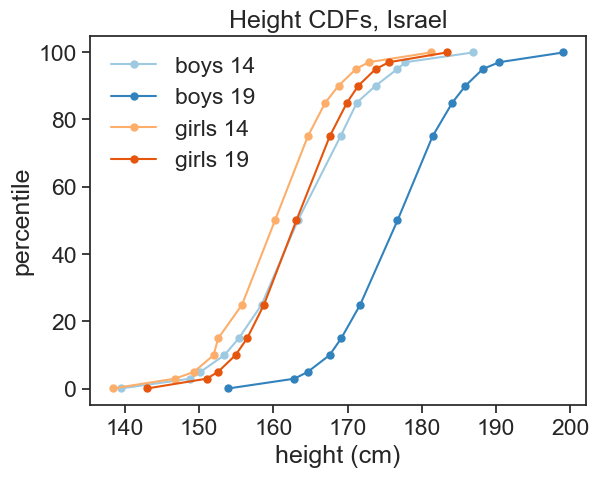

In [51]:
#| code-summary: "plot cdfs"
fig, ax = plt.subplots()

colors = plt.cm.tab20c.colors
color_boys_19 = colors[0]
color_boys_14 = colors[2]
color_girls_19 = colors[4]
color_girls_14 = colors[6]

ax.plot(df['height_boys_14'], df.index, label="boys 14", color=color_boys_14, marker='o', markersize=5)
ax.plot(df['height_boys_19'], df.index, label="boys 19", color=color_boys_19, marker='o', markersize=5)
ax.plot(df['height_girls_14'], df.index, label="girls 14", color=color_girls_14, marker='o', markersize=5)
ax.plot(df['height_girls_19'], df.index, label="girls 19", color=color_girls_19, marker='o', markersize=5)

ax.legend(frameon=False)
ax.set(xlabel='height (cm)',
       ylabel='percentile',
       title='Height CDFs, Israel')

## naming

From now on, I will call 14-year-old boys "boys", and 19-year-old boys "men". Of course, 14-year-old girls are "girls", and 19-year-old girls are "women".

## cdf
I would like to extract from the data the full cdf, for any height. I'll try to fit each dataset to the cumulative distribution function of the gaussian (normal) distribution:
$$
\Phi(x) = \frac{1}{2} \left( 1 + \text{erf}\left(\frac{x - \mu}{\sigma \sqrt{2}}\right) \right)
$$
where $\mu$ is the mean and $\sigma$ is the standard deviation of the distribution. The error function $\text{erf}$ is a sigmoid function, which is a good approximation for the cdf of the normal distribution.


In [55]:
#| code-summary: "fit data to erf function"
def erf_model(x, mu, sigma):
    return 50 * (1 + erf((x - mu) / (sigma * np.sqrt(2))) )
# initial guess for parameters: [mu, sigma]
p0 = [150, 20]
# fit the model

params14_boys, _ = curve_fit(erf_model, df['height_boys_14'].values, df.index.values, p0=p0)
params19_boys, _ = curve_fit(erf_model, df['height_boys_19'].values, df.index.values, p0=p0)
params14_girls, _ = curve_fit(erf_model, df['height_girls_14'].values, df.index.values, p0=p0)
params19_girls, _ = curve_fit(erf_model, df['height_girls_19'].values, df.index.values, p0=p0)

# Calculate R-squared
def calculate_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

# Predicted values
percentile_pred_14_boys = erf_model(df['height_boys_14'], *params14_boys)
percentile_pred_19_boys = erf_model(df['height_boys_19'], *params19_boys)
percentile_pred_14_girls = erf_model(df['height_girls_14'], *params14_girls)
percentile_pred_19_girls = erf_model(df['height_girls_19'], *params19_girls)
# R-squared value
r2_14_boys = calculate_r2(df.index, y_pred_14_boys)
r2_19_boys = calculate_r2(df.index, y_pred_19_boys)
r2_14_girls = calculate_r2(df.index, y_pred_14_girls)
r2_19_girls = calculate_r2(df.index, y_pred_19_girls)

print(f"Boys: μ={params14_boys[0]:.0f}cm, σ={params14_boys[1]:.0f}cm, R-squared={r2_14_boys:.4e}")
print(f"Men: μ={params19_boys[0]:.0f}cm, σ={params19_boys[1]:.0f}cm, R-squared={r2_19_boys:.4e}")
print(f"Gilrs: μ={params14_girls[0]:.0f}cm, σ={params14_girls[1]:.0f}cm, R-squared={r2_14_girls:.4e}")
print(f"Women: μ={params19_girls[0]:.0f}cm, σ={params19_girls[1]:.0f}cm, R-squared={r2_19_girls:.4e}")

Boys: μ=164cm, σ=8cm, R-squared=9.9975e-01
Men: μ=177cm, σ=7cm, R-squared=9.9996e-01
Gilrs: μ=160cm, σ=7cm, R-squared=9.9966e-01
Women: μ=163cm, σ=6cm, R-squared=9.9998e-01


[Text(0.5, 0, 'height (cm)'),
 Text(0, 0.5, 'percentile'),
 Text(0.5, 1.0, 'superb fit :)')]

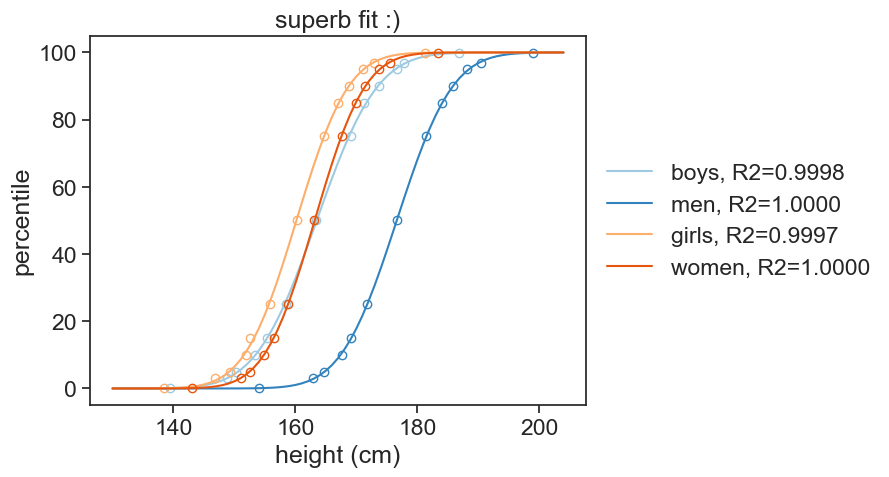

In [56]:
#| code-summary: "plot fitted curves"
fig, ax = plt.subplots()

h = np.arange(130, 205, 1)
cdf_fit_boys14 = erf_model(h, *params14_boys)
cdf_fit_boys19 = erf_model(h, *params19_boys)
cdf_fit_girls14 = erf_model(h, *params14_girls)
cdf_fit_girls19 = erf_model(h, *params19_girls)

ax.plot(df['height_boys_14'], df.index, ls='None', marker='o', markerfacecolor='None', color=color_boys_14)
ax.plot(h, cdf_fit_boys14, color=color_boys_14, label=f"boys, R2={r2_14_boys:.4f}")
ax.plot(df['height_boys_19'], df.index, ls='None', marker='o', markerfacecolor='None', color=color_boys_19)
ax.plot(h, cdf_fit_boys19, color=color_boys_19, label=f"men, R2={r2_19_boys:.4f}")
ax.plot(df['height_girls_14'], df.index, ls='None', marker='o', markerfacecolor='None', color=color_girls_14)
ax.plot(h, cdf_fit_girls14, color=color_girls_14, label=f"girls, R2={r2_14_girls:.4f}")
ax.plot(df['height_girls_19'], df.index, ls='None', marker='o', markerfacecolor='None', color=color_girls_19)
ax.plot(h, cdf_fit_girls19, color=color_girls_19, label=f"women, R2={r2_19_girls:.4f}")
# legend beside axes
ax.legend(loc="center left",
          bbox_to_anchor=(1.0,0.5),
          frameon=False,)
ax.set(xlabel='height (cm)',
       ylabel='percentile',
       title='superb fit :)')

## pdf

Now that we have the mean and standard deviation, we can plot the probability density function (pdf) for each group.

[Text(0.5, 0, 'height (cm)'),
 Text(0, 0.5, 'percentile'),
 Text(0.5, 1.0, 'superb fit :)')]

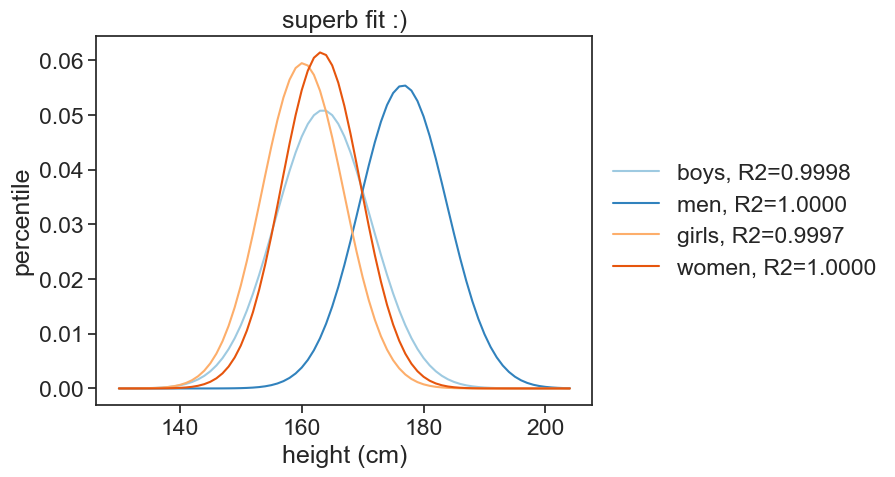

In [ ]:
from scipy.stats import norm

#| code-summary: "plot fitted curves"
fig, ax = plt.subplots()

# plot now pdfs
pdf_boys_14 = norm.pdf(h, loc=params14_boys[0], scale=params14_boys[1])
pdf_boys_19 = norm.pdf(h, loc=params19_boys[0], scale=params19_boys[1])
pdf_girls_14 = norm.pdf(h, loc=params14_girls[0], scale=params14_girls[1])
pdf_girls_19 = norm.pdf(h, loc=params19_girls[0], scale=params19_girls[1])

ax.plot(h, pdf_boys_14, color=color_boys_14, label=f"boys, R2={r2_14_boys:.4f}")
ax.plot(h, pdf_boys_19, color=color_boys_19, label=f"men, R2={r2_19_boys:.4f}")
ax.plot(h, pdf_girls_14, color=color_girls_14, label=f"girls, R2={r2_14_girls:.4f}")
ax.plot(h, pdf_girls_19, color=color_girls_19, label=f"women, R2={r2_19_girls:.4f}")
# legend beside axes
ax.legend(loc="center left",
          bbox_to_anchor=(1.0,0.5),
          frameon=False,)
ax.set(xlabel='height (cm)',
       ylabel='pdf',
       )

The graph above is very interesting!

* When girls are 14 year old, they have, on average, almost finished getting taller. The boys, on the other hand, still have a lot of growing to do.
* The average boy is as tall as an adult woman (both ~163 cm). Note, however, that the spread in the boys' distribution (7.8 cm) is higher than that of women (6.5 cm). This has a large effect on the tails of the distribution: a lot more boys will be super tall or super short.
